# Imports necessários

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

Constantes

In [2]:
N = 320 # número de espiras de cada bobina
Gs = 2
ub = 9.2740e-24 # J/T
h = 6.6260e-34 # planck Js
R = 6.8e-2 #cm -> m
u0 = 1.256e-6 # N/A
# medido com a régua
# distancia entre as bobinas foi confirmada como aproximadamente 6.1cm (conforme o item 2)
# as bobinas estão em paralelo
# corrente está sem série

constante = (ub * N * u0 * (4/5)**(3/2))/(h*R) 

# Dado coletado

In [3]:
data = {
    "I": [0.58, 0.63, 0.71, 0.79, 0.88, 0.92, 1, 1.06, 1.11, 1.17, 1.25],
    "MHz": [30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60]

}

Primeira observação do dado

In [4]:
df = pd.DataFrame(data)
df

,I,MHz
0,0.58,30
1,0.63,33
2,0.71,36
3,0.79,39
4,0.88,42
5,0.92,45
6,1.00,48
7,1.06,51
8,1.11,54
9,1.17,57


# Calculo do erro de I

In [5]:
df['I_err'] = df['I'] * 0.02 + 0.05

# Plot com erros

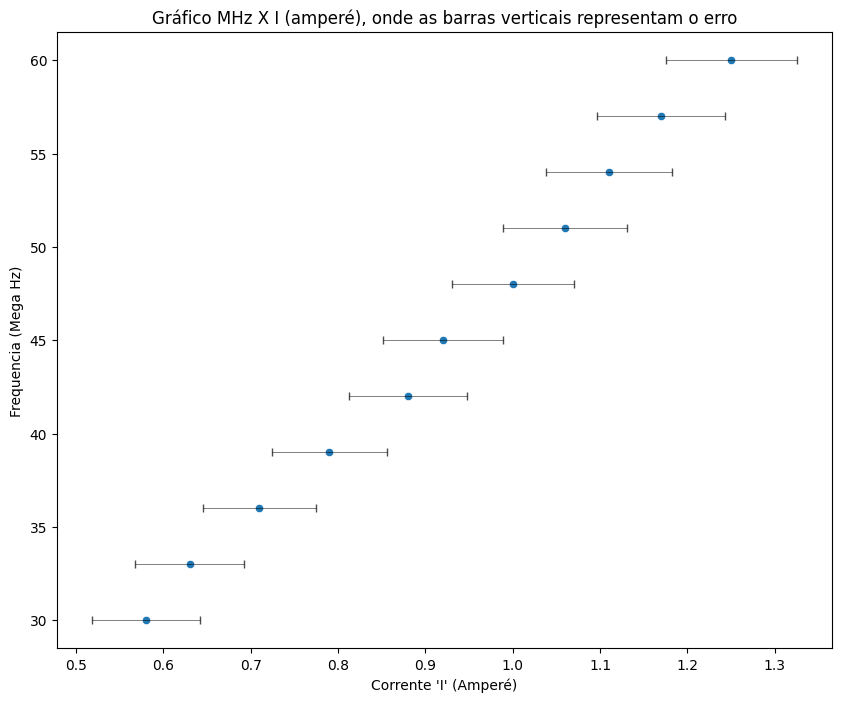

In [6]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=df, x='I', y='MHz')
plt.errorbar(
    df['I'], df['MHz'],
    xerr=df['I_err'],
    fmt='none', 
    ecolor='black',
    elinewidth=0.5,
    capsize=3,
    alpha=0.7
)
plt.title("Gráfico MHz X I (amperé), onde as barras verticais representam o erro")
plt.xlabel("Corrente 'I' (Amperé)")
plt.ylabel("Frequencia (Mega Hz)")
plt.show()

pela formula:

f = gs * ub * B / h

# Calculando B

In [7]:
# calculando B:
df['B'] = u0 * N * df['I'] * 8/(R * np.sqrt(125))

Regressão linear sem o "intercept", já que se fosse colocado não teria significado físico.

In [8]:
ln = LinearRegression(fit_intercept=False)

In [9]:
ln.fit(df[['B']], df[['MHz']] * 1e6)

LinearRegression(fit_intercept=False)

In [10]:
encontrado = ln.coef_[0][0] * h / ub
encontrado

np.float64(0.8241645173201024)

# Tratamento necessário para a plotagem abaixo

In [11]:
coef = ln.coef_[0][0]

In [12]:
coef = int(coef/1e6)

In [13]:
df['predicted'] = ln.predict(df[['B']])/1e6

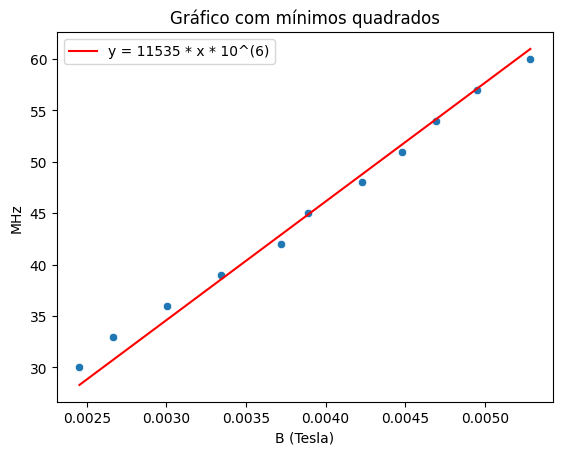

In [14]:
sns.scatterplot(data=df, x='B', y='MHz')
sns.lineplot(data=df, x='B', y='predicted', color='red', label=f'y = {coef} * x * 10^(6)')
plt.xlabel("B (Tesla)")
plt.ylabel("MHz")
plt.title("Gráfico com mínimos quadrados")
plt.show()

Simulação monte carlo para encontrar intervalo de confiança do nosso coef da regressão linear.

In [15]:
a_values = []
for _ in range(1000):
    # considerando que os erros de I_err são normais...
    x_synthetic = df['I'].values + np.random.normal(0, df['I_err'])
    x_synthetic = u0 * N * x_synthetic * (4/5) ** (3/2)/R
    
    X = x_synthetic.reshape(-1, 1)
    Y = df['MHz'].values.reshape(-1, 1) * 1e6
    
    model = LinearRegression(fit_intercept=False)
    model.fit(X, Y)
    
    a_values.append(model.coef_[0][0])

a_mean = np.mean(a_values)
a_std = np.std(a_values)

In [16]:
a_mean * h / ub

np.float64(0.8198738032780017)

In [17]:
erro_std = a_std * h / ub

In [18]:
print(f"{encontrado} +- {erro_std}")

0.8241645173201024 +- 0.017370543837323223


In [24]:
abs(encontrado - 2)/erro_std

np.float64(67.6913454001042)